In [1]:
# 安装依赖库
!pip install git+https://github.com/openai/CLIP.git -q
!pip install transformers -q
!pip install torchvision matplotlib -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.1 MB/s eta 0:00:00


In [2]:
import os
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# 设置随机种子保证可重复性
torch.manual_seed(42)

In [4]:

# 4. Download FoodSeg103 dataset
!wget -q https://research.larc.smu.edu.sg/downloads/datarepo/FoodSeg103.zip -P /content/datasets/
!unzip -q -P LARCdataset9947 /content/datasets/FoodSeg103.zip -d /content/datasets



In [6]:
# 食材识别模块
def image_recognition(image_path):
    # 加载CLIP模型
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    # 定义食材候选列表（这里使用FoodSeg103数据集中的部分类别，可根据需要扩展）
    ingredient_list = [
        "apple", "banana", "carrot", "broccoli", "tomato",
        "potato", "onion", "chicken", "egg", "flour",
        "milk", "cheese", "fish", "beef", "sugar",
        "candy", "egg tart", "french fries", "chocolate", "biscuit",
        "popcorn", "pudding", "ice cream", "cheese butter", "cake",
        "wine", "milkshake", "coffee", "juice", "milk",
        "tea", "almond", "red beans", "cashew", "dried cranberries",
        "soy", "walnut", "peanut", "avocado", "strawberry",
        "cherry", "blueberry", "raspberry", "mango", "olives",
        "peach", "lemon", "pear", "fig", "pineapple",
        "grape", "kiwi", "melon", "orange", "watermelon",
        "steak", "pork", "chicken duck", "sausage", "fried meat",
        "lamb", "sauce", "crab", "shellfish", "shrimp",
        "soup", "bread", "corn", "hamburg", "pizza",
        "hanamaki baozi", "wonton dumplings", "pasta", "noodles", "rice",
        "pie", "tofu", "eggplant", "garlic", "cauliflower",
        "kelp", "seaweed", "spring onion", "rape", "ginger",
        "okra", "lettuce", "pumpkin", "cucumber", "white radish",
        "asparagus", "bamboo shoots", "broccoli", "celery stick", "cilantro mint",
        "snow peas", "cabbage", "bean sprouts", "onion", "pepper",
        "green beans", "French beans", "king oyster mushroom", "shiitake", "enoki mushroom",
        "oyster mushroom", "white button mushroom", "salad", "other ingredients"
    ]

    try:
        img = Image.open(image_path)
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        return []

    # 预处理和模型推理
    image = preprocess(img).unsqueeze(0).to(device)
    text = clip.tokenize([f"a photo of {ingredient}" for ingredient in ingredient_list]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        logits_per_image, _ = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # 获取预测结果
    top_k = 3
    top_indices = probs.argsort()[0][-top_k:][::-1]
    predicted_ingredients = [ingredient_list[i] for i in top_indices]

    return predicted_ingredients

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 50.8MiB/s]


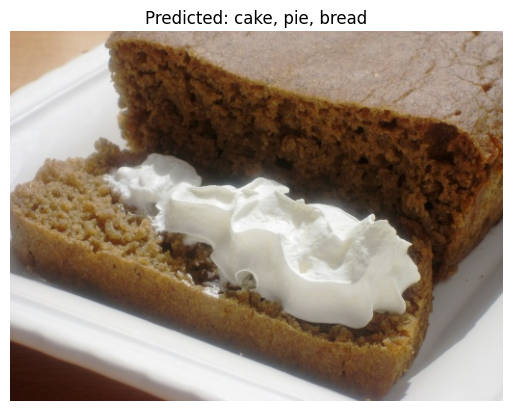

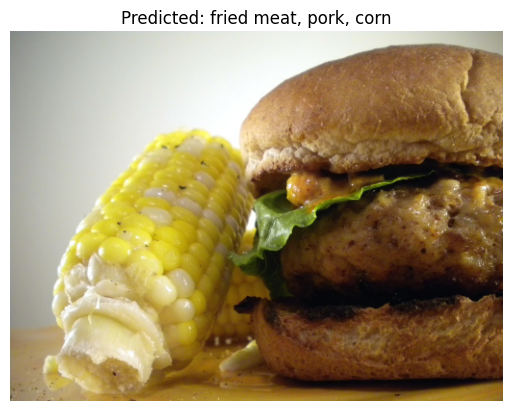

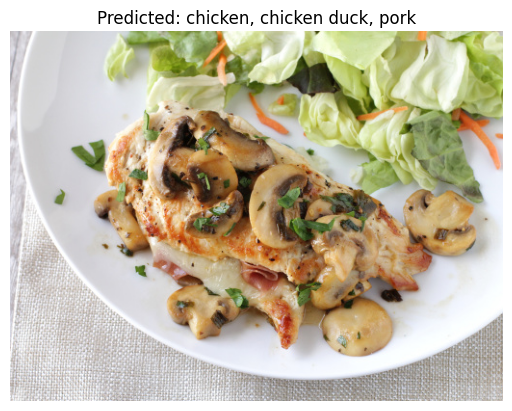

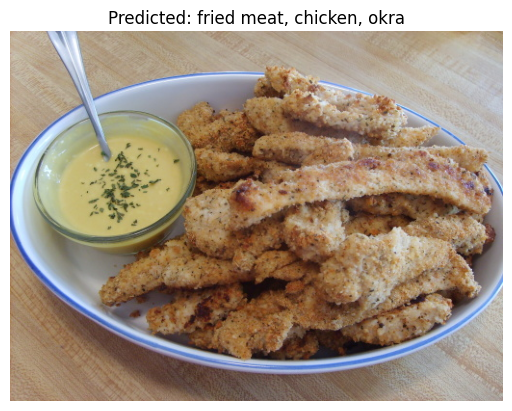

In [ ]:
# 主程序
if __name__ == "__main__":
    # Step 4: Prepare dataset paths
    root = '/content/datasets/FoodSeg103'
    image_dir = os.path.join(root, 'Images/img_dir/train')

    # 获取图像文件列表
    image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # 确保至少处理30张图像
    if len(image_files) < 30:
        print("图像数量不足30张，请检查数据集。")
    else:
        image_files = image_files[:30]

    # 处理每张图像
    for image_path in image_files:
        predicted_ingredients = image_recognition(image_path)
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {', '.join(predicted_ingredients)}")
        plt.show()